**Packages Import**

In [1]:
import os
import re
import pandas as pd
import numpy as np
import sys

from functools import cmp_to_key #comparing function 

import tqdm #progress bar

import preprocessor as prepro # twitter prepro
import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module
import en_core_web_sm
import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module



os.chdir('..')
# set max to rows and cols so series shows up complete, avoid truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth
np.set_printoptions(threshold=sys.maxsize)

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #vizualisation
# Import the wordcloud library
from wordcloud import WordCloud

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

pyLDAvis.enable_notebook()

#Visualisations

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import nltk.corpus #to use in building corpus for topic modelling

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.8). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Data & Processing & EDA

In [2]:
# import data 
jobs_df = pd.read_csv(r"D:\OneDrive - CBS - Copenhagen Business School\MSC24\DSforBussApplication\DSforBuss\Assignement 2\Job_search\\jobs.csv")

In [3]:
# check shape of df
print(jobs_df.shape)
# check how df looks
jobs_df.head(3)

(84090, 22)


,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,NaN,8.0,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,NaN,0.0,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,NaN,11.0,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC


In [4]:
# check how many unique values are in each column
print(jobs_df.nunique())

Job.ID                84090
Provider                  3
Status                    1
Slug                  84090
Title                 41861
Position              36245
Company                8335
City                   5503
State.Name               51
State.Code               51
Address                  24
Latitude              14452
Longitude             14641
Industry                  6
Requirements              0
Salary                   26
Listing.Start           146
Listing.End             144
Employment.Type           8
Education.Required        5
Created.At            59238
Updated.At            58981
dtype: int64


In [5]:
# check how Position column looks like
print(jobs_df["Position"].unique())

['Server' 'Kitchen Staff/Chef' 'Bartender' 'Receptionist' 'Driver'
 'Assistant Store Manager'
 'Store Associate - Retail Sales (Customer Service)'
 "Macy's Seasonal Retail Commission Sales Women's Shoes, Part Time - Skokie, IL - Old Orchard Mall"
 'Part Time Clerks Needed' 'Flex (Part Time) Merchandiser - Mullins, SC'
 'Child Psychotherapist'
 'Hiring Kitchen Positions - Experienced Line Cooks' 'HR Administrator'
 'Retail Gift Registry Advisor, Full Time/Part Time: Dayton, OH - Macy’s Dayton Mall'
 'Weekend Breakfast Attendant'
 'EMT - Growing Medical Transportation Company'
 'Part-Time Financial Operations Specialist (Undergraduate Student Program)'
 'Macy’s Seasonal Retail Stock Merchandising Part Time, Morning 5am-2pm - San Jose, CA - Oakridge'
 'Seasonal Retail Selling Floor Recovery, As Early As 11AM - San Mateo, CA -  Hillsdale Shopping Center'
 'Retail Administrative Support Team, Part Time: Westland, MI - Macy’s Westland Center'
 'Teaching Opportunties' 'Sales Professional'
 'I

In [6]:
# above it shows that Position and Title have much less unique values than the total of observations. However Slug column has same unique values as total observations. 
# below we check if there are many observations which duplicates in the combination Title & Position 
# If so we want to see if the Slug column gives enough info to consider these as unique and not as real duplicates 
duplicated_rows = jobs_df[jobs_df.duplicated(subset=['Title','Position'])]
print(duplicated_rows.shape) #check how many duplicates there are. 
duplicated_rows.head(5)

(42229, 22)


,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
14,134279,2,open,louisville-ky-kroger-louisville-part-time-cler...,Part Time Clerks Needed @ Kroger - Louisville,Part Time Clerks Needed,Kroger - Louisville,Louisville,Kentucky,KY,NaN,38.25486,-85.76640,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:12 UTC,2014-12-05 16:55:12 UTC
19,134284,2,open,louisville-ky-kroger-louisville-part-time-cler...,Part Time Clerks Needed @ Kroger - Louisville,Part Time Clerks Needed,Kroger - Louisville,Louisville,Kentucky,KY,NaN,38.25486,-85.76640,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:18 UTC,2014-12-05 16:55:18 UTC
20,134285,2,open,onalaska-wi-aldi-store-associate-retail-sales-...,Store Associate - Retail Sales (Customer Servi...,Store Associate - Retail Sales (Customer Service),ALDI,Onalaska,Wisconsin,WI,NaN,43.90650,-91.23340,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,High School Diploma,2014-12-05 16:55:19 UTC,2014-12-05 16:55:19 UTC
28,134296,2,open,chicago-il-michael-hill-sales-professional-134296,Sales Professional @ MICHAEL HILL,Sales Professional,MICHAEL HILL,Chicago,Illinois,IL,NaN,41.88415,-87.63241,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:36 UTC,2014-12-05 16:55:36 UTC
29,134297,2,open,chicago-il-michael-hill-sales-professional-134297,Sales Professional @ MICHAEL HILL,Sales Professional,MICHAEL HILL,Chicago,Illinois,IL,NaN,41.88415,-87.63241,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:38 UTC,2014-12-23 13:15:25 UTC


In [7]:
# seems slug is just string combining location, position and ending in job id => thus jobs can have duplicated 
# below all duplicates are dropped

jobs_df = jobs_df.drop_duplicates(subset=['Title','Position'])

Data conclusions:
   *  Column ['Position'] includes following info which is contained by other columns anyway: contract type info (e.g.part-time), location of employment, company for employment. While these features can be relevant in predicting education level needed, they are not relevant in predicting the industry for each positions

### Data Preprocessing

In [8]:
##Change . to _ so less issues when querying using cols name
jobs_df.columns = jobs_df.columns.str.replace('.', '_')

C:\Users\oanaa\AppData\Local\Temp\ipykernel_9816\3325937672.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  jobs_df.columns = jobs_df.columns.str.replace('.', '_')


In [9]:
# Function to remove info stored in another feature already, from Position column

def remove_existing_strings(series1,series2):

    container = []

    pbar = tqdm.tqdm(total=len(series1),position=0, leave=False)

    for i in range(0,len(series1)):

        element1 = str(series1.iloc[i])
        element2 = (" " + str(series2.iloc[i])) #add space before and after word so if it is inclued in another word it is not removed.
     
        if element2 in element1:
            element = element1.replace(element2,'')
       

        container.append(element1)
    

    return container

In [10]:
# Remove State_Name, City, State_Code, Employment_Type
jobs_df['clean_text_position'] = remove_existing_strings(jobs_df['Position'],jobs_df['State_Name'])
jobs_df['clean_text_position'] = remove_existing_strings(jobs_df['clean_text_position'],jobs_df['State_Code'])
jobs_df['clean_text_position'] = remove_existing_strings(jobs_df['clean_text_position'],jobs_df['City'])
jobs_df['clean_text_position'] = remove_existing_strings(jobs_df['clean_text_position'],jobs_df['Employment_Type'])


In [11]:
# some words like <time> still appear since they do not have a space in the begging.Also I want to get rid of all stop words 
# import stopwords
extra_stopwords = ["all", "flex", "time", "position", "seasonal", "available"]
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(extra_stopwords)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
# Function to clean text of Position column which now is in clean_text_position

# write everything into one function that can be re-used later
def text_cleaner(texts,stop_words):

#remove all punctuation  
  texts_clean = texts.apply(lambda t: t.lower())
 # texts_clean = texts.apply(lambda t: re.sub(r'[^a-zA-Z0-9]', ' ', t))
  
  clean_container = []

  # progress bar
  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)
   
  # nlp pipeline. tokanizes inside... 
  nlp_pipeline =  nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"])

  for text in nlp_pipeline:
    #text is an entire string (observation from Position)

    #here i just lowercase every element from string
    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct
          and (str(token).lower() not in stop_words) ==True
          ]

    
    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  
  return clean_container

In [13]:
# pre-process text
jobs_df['clean_text_position'] = text_cleaner(jobs_df['clean_text_position'],stop_words)


100%|██████████| 41861/41861 [00:23<00:00, 1788.41it/s]


In [14]:
jobs_df.head(3)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,NaN,8.0,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC,server
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,NaN,0.0,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC,kitchen staff chef
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,NaN,11.0,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC,bartender


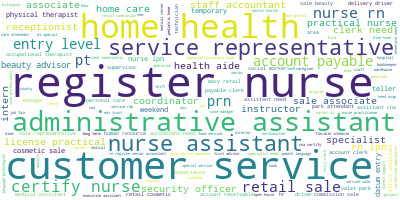

In [15]:
# Join the different processed titles together.
long_string = ','.join(list(jobs_df['clean_text_position'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [16]:
jobs_df['tokens'] = jobs_df['clean_text_position'].apply(lambda t: t.split())

In [17]:
jobs_df.head(3)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,NaN,8.0,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC,server,[server]
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,NaN,0.0,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC,kitchen staff chef,"[kitchen, staff, chef]"
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,NaN,11.0,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC,bartender,[bartender]


### Topic Modeling

In [18]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(jobs_df['tokens'])
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5)
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in jobs_df['tokens']]

In [19]:
# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=8, workers = 4, passes=10)

In [20]:
# Let's try to visualize
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [21]:
 # Let's Visualize
pyLDAvis.display(lda_display)

In [22]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.146*"nurse" + 0.067*"rn" + 0.060*"register" + 0.055*"home" + '
  '0.044*"health" + 0.038*"lpn" + 0.033*"certify" + 0.031*"cna" + 0.031*"care" '
  '+ 0.029*"assistant"'),
 (1,
  '0.099*"need" + 0.051*"manager" + 0.030*"assistant" + 0.029*"clerk" + '
  '0.027*"coordinator" + 0.027*"account" + 0.027*"teller" + 0.024*"office" + '
  '0.022*"company" + 0.020*"bookkeeper"'),
 (2,
  '0.128*"service" + 0.067*"customer" + 0.049*"representative" + '
  '0.042*"account" + 0.038*"clerk" + 0.031*"intern" + 0.024*"worker" + '
  '0.024*"opportunity" + 0.024*"payable" + 0.017*"specialist"'),
 (3,
  '0.082*"medical" + 0.045*"security" + 0.036*"officer" + 0.036*"center" + '
  '0.034*"specialist" + 0.022*"teacher" + 0.017*"st" + 0.015*"maintenance" + '
  '0.014*"technician" + 0.014*"technologist"'),
 (4,
  '0.099*"sale" + 0.062*"associate" + 0.049*"entry" + 0.038*"market" + '
  '0.031*"level" + 0.023*"datum" + 0.019*"specialist" + 0.019*"retail" + '
  '0.019*"server" + 0.018*"merchandiser"'),
 (5

In [87]:
lda_dict = {0:'Helth care', 
            1:'Corporate', 
            2:'White Collar', 
            3:'Non-white collar: driver, techer',
            4:'Sales',
            5:'Nurse and Care (Personal care)',
            6:'Specilized: accountant, therapist',
            7:'Service',
           '-':'-'}

In [88]:
#get all topics probabilitites
def classifier(texts):

  #get probabilities list for each observation in list of tuples format [(cluster_no, probability)...]
  texts_clean = texts.apply(lambda t: lda_model[dictionary.doc2bow(t)])

  # First: sort probabilities list by probability in desc order (list of tuples e.g. (cluster_no, probabilty))
  # Second: get cluster number of first element (highest probability) 
  # Third: convert cluster number (lda_dict key) to predefined cluser name (lda_dict value)

  ##############################################
  texts_clean = texts_clean.apply( lambda t: lda_dict[sorted(t, reverse=True, key=cmp_to_key(lambda item1, item2: item1[1] - item2[1]))[0][0]] )

  return texts_clean

In [89]:
jobs_df['LDA_Industry'] = classifier(jobs_df['tokens'])

In [90]:
jobs_df.head(50)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens,LDA_Industry,numeric_education,Predicted_Education
8,134273,2,open,mendham-nj-king-s-food-markets-assistant-store...,Assistant Store Manager @ King's Food Markets,Assistant Store Manager,King's Food Markets,Mendham,New Jersey,NJ,NaN,40.77600,-74.60100,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:06 UTC,2014-12-05 16:55:06 UTC,assistant store manager,"[assistant, store, manager]",Corporate,0,High School Diploma
9,134274,2,open,onalaska-wi-aldi-store-associate-retail-sales-...,Store Associate - Retail Sales (Customer Servi...,Store Associate - Retail Sales (Customer Service),ALDI,Onalaska,Wisconsin,WI,NaN,43.90650,-91.23340,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,High School Diploma,2014-12-05 16:55:07 UTC,2014-12-05 16:55:07 UTC,store associate retail sale customer service,"[store, associate, retail, sale, customer, ser...",Sales,1,High School Diploma
10,134275,2,open,skokie-il-macy-s-macy-s-seasonal-retail-commis...,Macy's Seasonal Retail Commission Sales Women'...,Macy's Seasonal Retail Commission Sales Women'...,Macy's,Skokie,Illinois,IL,NaN,42.03450,-87.75780,NaN,NaN,NaN,12-05-2014,01-04-2015,Seasonal/Temp,Not Specified,2014-12-05 16:55:08 UTC,2014-12-05 16:55:08 UTC,macy retail commission sale woman shoe skokie ...,"[macy, retail, commission, sale, woman, shoe, ...","Specilized: accountant, therapist",0,High School Diploma
11,134276,2,open,louisville-ky-kroger-louisville-part-time-cler...,Part Time Clerks Needed @ Kroger - Louisville,Part Time Clerks Needed,Kroger - Louisville,Louisville,Kentucky,KY,NaN,38.25486,-85.76640,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:09 UTC,2014-12-05 16:55:09 UTC,clerk need,"[clerk, need]",Corporate,0,High School Diploma
12,134277,2,open,mullins-sc-coca-cola-bottling-company-consolid...,"Flex (Part Time) Merchandiser - Mullins, SC @ ...","Flex (Part Time) Merchandiser - Mullins, SC",Coca-Cola Bottling Company Consolidated,Mullins,South Carolina,SC,NaN,34.18930,-79.25890,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:10 UTC,2014-12-05 16:55:10 UTC,merchandiser mullins sc,"[merchandiser, mullins, sc]",Sales,0,High School Diploma
13,134278,2,open,philadelphia-pa-catch-inc-child-psychotherapis...,"Child Psychotherapist @ CATCH, Inc.",Child Psychotherapist,"CATCH, Inc.",Philadelphia,Pennsylvania,PA,NaN,39.93890,-75.18240,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,Master's Degree,2014-12-05 16:55:11 UTC,2014-12-05 16:55:11 UTC,child psychotherapist,"[child, psychotherapist]",Nurse and Care (Personal care),2,High School Diploma
15,134280,2,open,southern-pines-nc-longhorn-steakhouse-hiring-k...,Hiring Kitchen Positions - Experienced Line Co...,Hiring Kitchen Positions - Experienced Line Cooks,LongHorn Steakhouse,Southern Pines,North Carolina,NC,NaN,35.17440,-79.39149,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,Not Specified,2014-12-05 16:55:13 UTC,2014-12-05 16:55:13 UTC,hire kitchen position experience line cook,"[hire, kitchen, position, experience, line, cook]","Specilized: accountant, therapist",0,High School Diploma
16,134281,2,open,elizabeth-nj-new-york-community-bank-hr-admini...,HR Administrator @ New York Community Bank,HR Administrator,New York Community Bank,Elizabeth,New Jersey,NJ,NaN,40.67090,-74.17900,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:14 UTC,2014-12-05 16:55:14 UTC,hr administrator,"[hr, administrator]",Corporate,0,High School Diploma
17,134282,2,open,dayton-oh-macy-s-retail-gift-registry-advisor-...,"Retail Gift Registry Advisor, Full Time/Part T...","Retail Gift Registry Advisor, Full Time/Part T...",Macy's,Dayton,Ohio,OH,NaN,39.64680,-84.16830,NaN,NaN,NaN,12-05-2014,01-04-2015,Fu

## Prediction Modelling: Education Requirement ##

### EDA focused on Education Requirement

In [27]:
# see unique values of feature
print(jobs_df['Education_Required'].unique())

#check how many values are na
print(jobs_df['Education_Required'].isna().sum())

[nan 'Not Specified' 'High School Diploma' "Master's Degree"
 'Associate Degree' "Bachelor's Degree"]
219


In [28]:
# since so few are na, I decided to drop those rows
jobs_df = jobs_df.dropna(subset=['Education_Required'])

In [29]:
jobs_df.head(3)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens,LDA_Industry
8,134273,2,open,mendham-nj-king-s-food-markets-assistant-store...,Assistant Store Manager @ King's Food Markets,Assistant Store Manager,King's Food Markets,Mendham,New Jersey,NJ,NaN,40.7760,-74.6010,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:06 UTC,2014-12-05 16:55:06 UTC,assistant store manager,"[assistant, store, manager]",Retail
9,134274,2,open,onalaska-wi-aldi-store-associate-retail-sales-...,Store Associate - Retail Sales (Customer Servi...,Store Associate - Retail Sales (Customer Service),ALDI,Onalaska,Wisconsin,WI,NaN,43.9065,-91.2334,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,High School Diploma,2014-12-05 16:55:07 UTC,2014-12-05 16:55:07 UTC,store associate retail sale customer service,"[store, associate, retail, sale, customer, ser...",Sales
10,134275,2,open,skokie-il-macy-s-macy-s-seasonal-retail-commis...,Macy's Seasonal Retail Commission Sales Women'...,Macy's Seasonal Retail Commission Sales Women'...,Macy's,Skokie,Illinois,IL,NaN,42.0345,-87.7578,NaN,NaN,NaN,12-05-2014,01-04-2015,Seasonal/Temp,Not Specified,2014-12-05 16:55:08 UTC,2014-12-05 16:55:08 UTC,macy retail commission sale woman shoe skokie ...,"[macy, retail, commission, sale, woman, shoe, ...","Specilized: denatl, therapy"


In [30]:
#create df to see how many observations each education category has
counts_education_values = jobs_df['Education_Required'].value_counts().reset_index()
counts_education_values= counts_education_values.rename(columns={'Education_Required':'Observations'})

In [31]:
counts_education_values

,index,Observations
0,Not Specified,28612
1,High School Diploma,7533
2,Associate Degree,2399
3,Bachelor's Degree,2333
4,Master's Degree,765


In [32]:
#shows large number of not specified
alt.Chart(counts_education_values).mark_bar(filled=True).encode(
    alt.X('Observations:Q', title='No. observations'),
    alt.Y('index:N', title='Category')
)

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Since many of the observations have a *Not Specified* value when it comes to Education.Requirement I will try to see if some of these can be
filled by looking at positings which have the same job . To do so I will generate wordcloud for each of the categories 

LDA_Industry         Non-white collar: driver, techer  \
Education_Required                                      
Associate Degree                                  150   
Bachelor's Degree                                 214   
High School Diploma                              1239   
Master's Degree                                    54   
Not Specified                                    3479   

LDA_Industry         Nurse and Care (Personal care)  Other white collar  \
Education_Required                                                        
Associate Degree                                348                 134   
Bachelor's Degree                               420                 301   
High School Diploma                            1058                 926   
Master's Degree                                 176                 122   
Not Specified                                  3097                3968   

LDA_Industry         Retail  Sales  Specilized: denatl, therapy  \
Educati

<AxesSubplot:xlabel='Education_Required'>

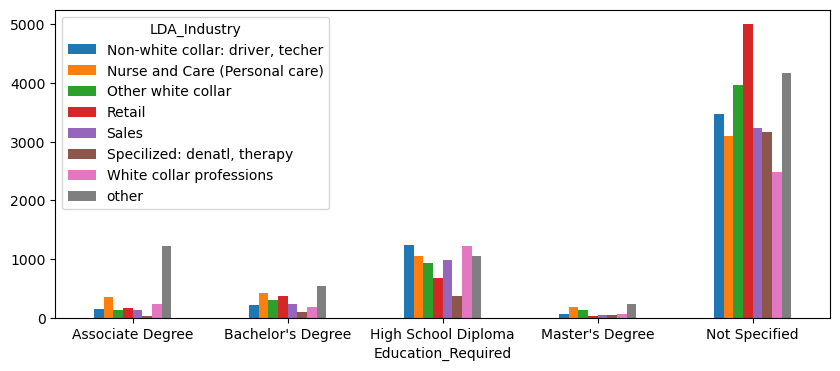

In [33]:
# Cross tabulation between education required and LDA_industry 
CrosstabResult=pd.crosstab(index=jobs_df['Education_Required'],columns=jobs_df['LDA_Industry'])
print(CrosstabResult)
 
# Grouped bar chart between GENDER and APPROVE_LOAN
CrosstabResult.plot.bar(figsize=(10,4), rot=0)

Employment_Type      Full-Time  Full-Time/Part-Time  Intern  Part-Time  \
Education_Required                                                       
Associate Degree            11                  714      47       1162   
Bachelor's Degree            0                  630      97       1025   
High School Diploma          2                 1894     114       4304   
Master's Degree              0                  191       8        409   
Not Specified                3                 5176     489      11259   

Employment_Type      Per Diem  Seasonal/Temp  
Education_Required                            
Associate Degree          349            116  
Bachelor's Degree         359            222  
High School Diploma       505            714  
Master's Degree           132             25  
Not Specified            1918           9767  


<AxesSubplot:xlabel='Education_Required'>

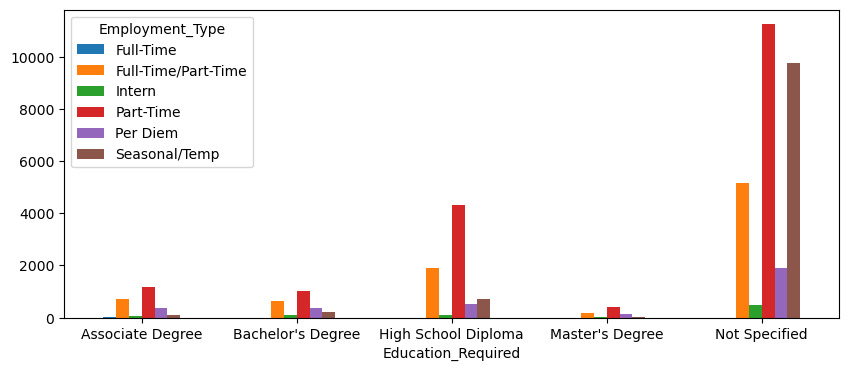

In [34]:
# Cross tabulation between education required and LDA_industry 
CrosstabResult=pd.crosstab(index=jobs_df['Education_Required'],columns=jobs_df['Employment_Type'])
print(CrosstabResult)
 
# Grouped bar chart between GENDER and APPROVE_LOAN
CrosstabResult.plot.bar(figsize=(10,4), rot=0)

In [35]:
part_time_df =  jobs_df.query('Employment_Type =="Part-Time" & Education_Required!="Not Specified" ')
part_time_df.head(30)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens,LDA_Industry
38,134307,2,open,new-brunswick-nj-kelly-it-resources-intern-net...,Intern - Network SharePoint Web Development In...,Intern - Network SharePoint Web Development In...,Kelly IT Resources,New Brunswick,New Jersey,NJ,NaN,40.48710,-74.44540,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Bachelor's Degree,2014-12-05 16:55:45 UTC,2014-12-05 16:55:45 UTC,intern network sharepoint web development intern,"[intern, network, sharepoint, web, development...",Other white collar
39,134308,2,open,cleveland-oh-volunteers-of-america-greater-ohi...,Residential Monitor @ Volunteers of America Gr...,Residential Monitor,Volunteers of America Greater Ohio,Cleveland,Ohio,OH,NaN,41.55824,-81.57548,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,High School Diploma,2014-12-05 16:55:46 UTC,2014-12-05 16:55:46 UTC,residential monitor,"[residential, monitor]",Nurse and Care (Personal care)
40,134309,2,open,bountiful-ut-south-davis-community-hospital-re...,Respiratory Therapist @ South Davis Community ...,Respiratory Therapist,South Davis Community Hospital,Bountiful,Utah,UT,NaN,40.88521,-111.87237,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Bachelor's Degree,2014-12-05 16:55:47 UTC,2014-12-05 16:55:47 UTC,respiratory therapist,"[respiratory, therapist]",Nurse and Care (Personal care)
54,134327,2,open,long-beach-ca-american-golf-corporation-snack-...,Snack Bar Attendant @ American Golf Corporation,Snack Bar Attendant,American Golf Corporation,Long Beach,California,CA,NaN,33.78340,-118.15060,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,High School Diploma,2014-12-05 16:56:03 UTC,2014-12-05 16:56:03 UTC,snack bar attendant,"[snack, bar, attendant]","Non-white collar: driver, techer"
55,134328,2,open,oceanside-ca-american-golf-corporation-head-go...,Head Golf Professional @ American Golf Corpora...,Head Golf Professional,American Golf Corporation,Oceanside,California,CA,NaN,33.20090,-117.28560,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,High School Diploma,2014-12-05 16:56:04 UTC,2014-12-05 16:56:04 UTC,head golf professional,"[head, golf, professional]","Specilized: denatl, therapy"
56,134332,2,open,saint-petersburg-fl-united-natural-foods-inc-d...,Deli Associate (2945-935) @ United Natural Foo...,Deli Associate (2945-935),"United Natural Foods, Inc.",Saint Petersburg,Florida,FL,NaN,27.78980,-82.72650,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,High School Diploma,2014-12-05 16:56:09 UTC,2014-12-05 16:56:09 UTC,deli associate,"[deli, associate]",Other white collar
58,134334,2,open,kokomo-in-kirby-risk-corporation-part-time-bra...,Part Time Branch Driver @ Kirby Risk Corporation,Part Time Branch Driver,Kirby Risk Corporation,Kokomo,Indiana,IN,NaN,40.48651,-86.12624,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,High School Diploma,2014-12-05 16:56:12 UTC,2014-12-05 16:56:12 UTC,branch driver,"[branch, driver]","Non-white collar: driver, techer"
60,134340,2,open,san-antonio-tx-university-health-system-staff-...,Staff Nurse I @ University Health System,Staff Nurse I,University Health System,San Antonio,Texas,TX,NaN,29.42449,-98.49462,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Bachelor's Degree,2014-12-05 16:56:17 UTC,2014-12-05 16:56:17 UTC,staff nurse,"[staff, nurse]",other
63,134345,2,open,charleston-wv-service-corporation-internationa...,Funeral Attendant- Tyler Mountain Memorial Gar...,Funeral Attendant- Tyler Mountain Memorial Gar...,Service Corporation International,Charleston,West Virginia,WV,NaN,38.41990,-81.75090,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,High School Diploma,2014-12-05 16:56:24 UTC,2014-12-05 16:56:24 UTC,funeral tyler mountain memorial garden,"[funeral, tyler, mountain, memorial, garden]","Specilized: denatl, therapy"
64,134346,2,open,rochester-wa-lucky-eagle-casino-soft-count-tea...,Soft 

LDA_Industry         Non-white collar: driver, techer  \
Education_Required                                      
Associate Degree                                   99   
Bachelor's Degree                                  87   
High School Diploma                               723   
Master's Degree                                    28   

LDA_Industry         Nurse and Care (Personal care)  Other white collar  \
Education_Required                                                        
Associate Degree                                225                  51   
Bachelor's Degree                               219                 119   
High School Diploma                             603                 500   
Master's Degree                                 103                  53   

LDA_Industry         Retail  Sales  Specilized: denatl, therapy  \
Education_Required                                                
Associate Degree         76     35                           12   
Bache

<AxesSubplot:xlabel='Education_Required'>

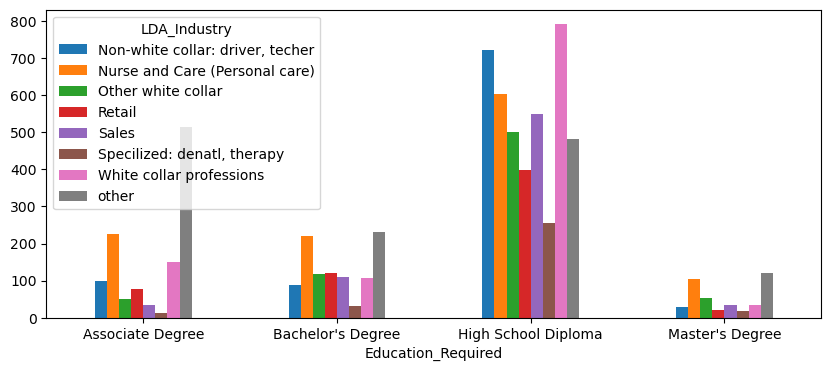

In [36]:
# Cross tabulation between education required and LDA_industry 
CrosstabResult=pd.crosstab(index=part_time_df['Education_Required'],columns=part_time_df['LDA_Industry'])
print(CrosstabResult)
 
# Grouped bar chart between GENDER and APPROVE_LOAN
CrosstabResult.plot.bar(figsize=(10,4), rot=0)

In [37]:
jobs_df.head(3)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens,LDA_Industry
8,134273,2,open,mendham-nj-king-s-food-markets-assistant-store...,Assistant Store Manager @ King's Food Markets,Assistant Store Manager,King's Food Markets,Mendham,New Jersey,NJ,NaN,40.7760,-74.6010,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:06 UTC,2014-12-05 16:55:06 UTC,assistant store manager,"[assistant, store, manager]",Retail
9,134274,2,open,onalaska-wi-aldi-store-associate-retail-sales-...,Store Associate - Retail Sales (Customer Servi...,Store Associate - Retail Sales (Customer Service),ALDI,Onalaska,Wisconsin,WI,NaN,43.9065,-91.2334,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,High School Diploma,2014-12-05 16:55:07 UTC,2014-12-05 16:55:07 UTC,store associate retail sale customer service,"[store, associate, retail, sale, customer, ser...",Sales
10,134275,2,open,skokie-il-macy-s-macy-s-seasonal-retail-commis...,Macy's Seasonal Retail Commission Sales Women'...,Macy's Seasonal Retail Commission Sales Women'...,Macy's,Skokie,Illinois,IL,NaN,42.0345,-87.7578,NaN,NaN,NaN,12-05-2014,01-04-2015,Seasonal/Temp,Not Specified,2014-12-05 16:55:08 UTC,2014-12-05 16:55:08 UTC,macy retail commission sale woman shoe skokie ...,"[macy, retail, commission, sale, woman, shoe, ...","Specilized: denatl, therapy"


## NLP

In [38]:
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.svm import SVC # for Support Vector Classification baseline model
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [39]:
unique_vals_list = jobs_df.Education_Required.unique().tolist()

In [40]:
#numerically ecoded education dictionary 
unique_vals_dict = {}

for element in unique_vals_list:
    unique_vals_dict[element] = unique_vals_list.index(element)

unique_vals_dict

{'Not Specified': 0,
 'High School Diploma': 1,
 "Master's Degree": 2,
 'Associate Degree': 3,
 "Bachelor's Degree": 4}

In [41]:
jobs_df['numeric_education'] = jobs_df['Education_Required'].map(unique_vals_dict)    

In [42]:
jobs_df.head(3)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens,LDA_Industry,numeric_education
8,134273,2,open,mendham-nj-king-s-food-markets-assistant-store...,Assistant Store Manager @ King's Food Markets,Assistant Store Manager,King's Food Markets,Mendham,New Jersey,NJ,NaN,40.7760,-74.6010,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:06 UTC,2014-12-05 16:55:06 UTC,assistant store manager,"[assistant, store, manager]",Retail,0
9,134274,2,open,onalaska-wi-aldi-store-associate-retail-sales-...,Store Associate - Retail Sales (Customer Servi...,Store Associate - Retail Sales (Customer Service),ALDI,Onalaska,Wisconsin,WI,NaN,43.9065,-91.2334,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,High School Diploma,2014-12-05 16:55:07 UTC,2014-12-05 16:55:07 UTC,store associate retail sale customer service,"[store, associate, retail, sale, customer, ser...",Sales,1
10,134275,2,open,skokie-il-macy-s-macy-s-seasonal-retail-commis...,Macy's Seasonal Retail Commission Sales Women'...,Macy's Seasonal Retail Commission Sales Women'...,Macy's,Skokie,Illinois,IL,NaN,42.0345,-87.7578,NaN,NaN,NaN,12-05-2014,01-04-2015,Seasonal/Temp,Not Specified,2014-12-05 16:55:08 UTC,2014-12-05 16:55:08 UTC,macy retail commission sale woman shoe skokie ...,"[macy, retail, commission, sale, woman, shoe, ...","Specilized: denatl, therapy",0


In [43]:
labeled_df = jobs_df[jobs_df['numeric_education']!= 0]
unlabeled_df = jobs_df[jobs_df['numeric_education']==0]


In [44]:
# renaming and reordering

data_df = pd.DataFrame({'label':labeled_df['numeric_education'], 'text':labeled_df['clean_text_position']})

In [45]:
data_df.label.value_counts().reset_index()

,index,label
0,1,7533
1,3,2399
2,4,2333
3,2,765


In [46]:
# sampling, splitting
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [47]:
# ffixing sample imbalance, since very little data I oversampled
rus = RandomOverSampler(random_state=42)
data_df_res, y_res = rus.fit_resample(labeled_df, labeled_df['numeric_education'])

In [48]:
data_df_res['numeric_education'].value_counts()

1    7533
2    7533
3    7533
4    7533
Name: numeric_education, dtype: int64

In [49]:
# Splitting the dataset into the Training set and Test set (since we have a new output variable)
X_train, X_test, y_train, y_test = train_test_split(labeled_df['clean_text_position'], labeled_df['numeric_education'], test_size = 0.4, random_state = 42)

In [50]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls = LogisticRegression()

pipe = make_pipeline(tfidf, cls)

In [51]:
pipe.fit(X_train,y_train) # fit model

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [52]:
# evaluate model performance on training set

y_eval = pipe.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

           1       0.85      0.95      0.90      4496
           2       0.79      0.53      0.64       444
           3       0.75      0.65      0.70      1474
           4       0.73      0.63      0.68      1404

    accuracy                           0.81      7818
   macro avg       0.78      0.69      0.73      7818
weighted avg       0.81      0.81      0.80      7818



In [53]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls = LogisticRegression()

pipe = make_pipeline(tfidf, cls)

In [54]:
pipe.fit(X_train,y_train) # fit model

c:\Users\oanaa\anaconda3\envs\CodeBase\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [55]:
# evaluate model performance on training set

y_eval = pipe.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

           1       0.85      0.95      0.90      4496
           2       0.79      0.53      0.64       444
           3       0.75      0.65      0.70      1474
           4       0.73      0.63      0.68      1404

    accuracy                           0.81      7818
   macro avg       0.78      0.69      0.73      7818
weighted avg       0.81      0.81      0.80      7818



In [56]:
unique_vals_dict =  {v: k for k, v in unique_vals_dict.items()}

In [57]:
unique_vals_dict

{0: 'Not Specified',
 1: 'High School Diploma',
 2: "Master's Degree",
 3: 'Associate Degree',
 4: "Bachelor's Degree"}

In [58]:
jobs_df['Predicted_Education'] = pipe.predict(jobs_df['clean_text_position'])

In [59]:
jobs_df['Predicted_Education']= jobs_df['Predicted_Education'].map(unique_vals_dict)

In [60]:
jobs_df.head(25)

,Job_ID,Provider,Status,Slug,Title,Position,Company,City,State_Name,State_Code,Address,Latitude,Longitude,Industry,Requirements,Salary,Listing_Start,Listing_End,Employment_Type,Education_Required,Created_At,Updated_At,clean_text_position,tokens,LDA_Industry,numeric_education,Predicted_Education
8,134273,2,open,mendham-nj-king-s-food-markets-assistant-store...,Assistant Store Manager @ King's Food Markets,Assistant Store Manager,King's Food Markets,Mendham,New Jersey,NJ,NaN,40.77600,-74.60100,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:06 UTC,2014-12-05 16:55:06 UTC,assistant store manager,"[assistant, store, manager]",Retail,0,High School Diploma
9,134274,2,open,onalaska-wi-aldi-store-associate-retail-sales-...,Store Associate - Retail Sales (Customer Servi...,Store Associate - Retail Sales (Customer Service),ALDI,Onalaska,Wisconsin,WI,NaN,43.90650,-91.23340,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,High School Diploma,2014-12-05 16:55:07 UTC,2014-12-05 16:55:07 UTC,store associate retail sale customer service,"[store, associate, retail, sale, customer, ser...",Sales,1,High School Diploma
10,134275,2,open,skokie-il-macy-s-macy-s-seasonal-retail-commis...,Macy's Seasonal Retail Commission Sales Women'...,Macy's Seasonal Retail Commission Sales Women'...,Macy's,Skokie,Illinois,IL,NaN,42.03450,-87.75780,NaN,NaN,NaN,12-05-2014,01-04-2015,Seasonal/Temp,Not Specified,2014-12-05 16:55:08 UTC,2014-12-05 16:55:08 UTC,macy retail commission sale woman shoe skokie ...,"[macy, retail, commission, sale, woman, shoe, ...","Specilized: denatl, therapy",0,High School Diploma
11,134276,2,open,louisville-ky-kroger-louisville-part-time-cler...,Part Time Clerks Needed @ Kroger - Louisville,Part Time Clerks Needed,Kroger - Louisville,Louisville,Kentucky,KY,NaN,38.25486,-85.76640,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:09 UTC,2014-12-05 16:55:09 UTC,clerk need,"[clerk, need]",Retail,0,High School Diploma
12,134277,2,open,mullins-sc-coca-cola-bottling-company-consolid...,"Flex (Part Time) Merchandiser - Mullins, SC @ ...","Flex (Part Time) Merchandiser - Mullins, SC",Coca-Cola Bottling Company Consolidated,Mullins,South Carolina,SC,NaN,34.18930,-79.25890,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:10 UTC,2014-12-05 16:55:10 UTC,merchandiser mullins sc,"[merchandiser, mullins, sc]",Sales,0,High School Diploma
13,134278,2,open,philadelphia-pa-catch-inc-child-psychotherapis...,"Child Psychotherapist @ CATCH, Inc.",Child Psychotherapist,"CATCH, Inc.",Philadelphia,Pennsylvania,PA,NaN,39.93890,-75.18240,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,Master's Degree,2014-12-05 16:55:11 UTC,2014-12-05 16:55:11 UTC,child psychotherapist,"[child, psychotherapist]",Nurse and Care (Personal care),2,High School Diploma
15,134280,2,open,southern-pines-nc-longhorn-steakhouse-hiring-k...,Hiring Kitchen Positions - Experienced Line Co...,Hiring Kitchen Positions - Experienced Line Cooks,LongHorn Steakhouse,Southern Pines,North Carolina,NC,NaN,35.17440,-79.39149,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,Not Specified,2014-12-05 16:55:13 UTC,2014-12-05 16:55:13 UTC,hire kitchen position experience line cook,"[hire, kitchen, position, experience, line, cook]","Specilized: denatl, therapy",0,High School Diploma
16,134281,2,open,elizabeth-nj-new-york-community-bank-hr-admini...,HR Administrator @ New York Community Bank,HR Administrator,New York Community Bank,Elizabeth,New Jersey,NJ,NaN,40.67090,-74.17900,NaN,NaN,NaN,12-05-2014,01-04-2015,Part-Time,Not Specified,2014-12-05 16:55:14 UTC,2014-12-05 16:55:14 UTC,hr administrator,"[hr, administrator]",Retail,0,High School Diploma
17,134282,2,open,dayton-oh-macy-s-retail-gift-registry-advisor-...,"Retail Gift Registry Advisor, Full Time/Part T...","Retail Gift Registry Advisor, Full Time/Part T...",Macy's,Dayton,Ohio,OH,NaN,39.64680,-84.16830,NaN,NaN,NaN,12-05-2014,01-04-2015,Full-Time/Part-Time,Not

## Job Recommandation ##

In [61]:
df_interest = pd.read_csv(r"D:\OneDrive - CBS - Copenhagen Business School\MSC24\DSforBussApplication\DSforBuss\Assignement 2\Job_search\\user_work_interest.csv")
df_experience = pd.read_csv(r"D:\OneDrive - CBS - Copenhagen Business School\MSC24\DSforBussApplication\DSforBuss\Assignement 2\Job_search\\user_past_experience.csv")
df_views = pd.read_csv(r"D:\OneDrive - CBS - Copenhagen Business School\MSC24\DSforBussApplication\DSforBuss\Assignement 2\Job_search\\user_job_views.csv")

In [62]:
df_interest.head(3)

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
0,10003,security officer,2014-12-12 21:20:54 UTC,2014-12-12 21:20:54 UTC
1,10007,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
2,10007,Bartender,2014-08-14 15:56:44 UTC,2015-02-19 23:21:28 UTC


In [63]:
df_experience.head(3)

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC


In [64]:
print(df_views.shape)
df_views.head(3)

(12370, 13)


,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC


In [65]:
df_list = [df_views,df_experience,df_interest]

for element in df_list:
    element.columns = element.columns.str.replace('.', '_')

C:\Users\oanaa\AppData\Local\Temp\ipykernel_9816\1847937866.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  element.columns = element.columns.str.replace('.', '_')
C:\Users\oanaa\AppData\Local\Temp\ipykernel_9816\1847937866.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  element.columns = element.columns.str.replace('.', '_')
C:\Users\oanaa\AppData\Local\Temp\ipykernel_9816\1847937866.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  element.columns = element.columns.str.replace('.', '_')


In [66]:
# select name and IDs
data_select = df_views[['Applicant_ID', 'Job_ID', 'Title']]

In [67]:
# create edge DF by merge with itself.
edges = pd.merge(data_select, data_select, on='Job_ID')
edges.head()

,Applicant_ID_x,Job_ID,Title_x,Applicant_ID_y,Title_y
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,10000,Cashiers & Valets Needed! @ WallyPark
1,10000,73666,Cashiers & Valets Needed! @ WallyPark,11268,Cashiers & Valets Needed! @ WallyPark
2,10000,73666,Cashiers & Valets Needed! @ WallyPark,11478,Cashiers & Valets Needed! @ WallyPark
3,11268,73666,Cashiers & Valets Needed! @ WallyPark,10000,Cashiers & Valets Needed! @ WallyPark
4,11268,73666,Cashiers & Valets Needed! @ WallyPark,11268,Cashiers & Valets Needed! @ WallyPark


In [68]:
# Filter out self-edges
edges = edges[edges.Applicant_ID_x != edges.Applicant_ID_y]

In [69]:
# grouping to aggregate multiple co-occurences and to generate a weight: 
# How many times did PesonX and PersonY sit in boards together
# reset_index makes everytging from a multi-index-series into a dataframe
edges = edges.groupby(['Applicant_ID_x', 'Applicant_ID_y']).size().reset_index()

In [70]:
edges.head()

,Applicant_ID_x,Applicant_ID_y,0
0,42,601,5
1,42,2075,1
2,42,6092,1
3,42,6808,9
4,42,8645,8


In [71]:
edges[0].value_counts()

1     11982
2      4906
3      2372
4      1448
6       802
8       298
9       230
5       134
12      124
7        58
10       44
16       34
11       28
18       22
24       12
15        8
14        6
30        4
20        4
13        4
22        4
32        4
54        2
48        2
93        2
36        2
Name: 0, dtype: int64

In [72]:
# finally we rename the "0" column to weight
edges.rename({0:'weight'}, axis = 1, inplace=True)

In [73]:
import networkx as nx

In [74]:
# Create network object from pandas edgelist
G = nx.from_pandas_edgelist(edges, source='Applicant_ID_x', target='Applicant_ID_y', edge_attr='weight', create_using=nx.Graph())

In [75]:
# We can create a node-attribute dictionary directly from the dataframe (using pandas to_dict)

node_attributes = data_select[['Job_ID','Title']].set_index('Job_ID').drop_duplicates().to_dict('index')

In [76]:
# We now can include the degree as node-attribute
nx.set_node_attributes(G, {G.degree(): 'degree'})

In [77]:
# and use the node_attribute object to include all that in the graph object
nx.set_node_attributes(G, node_attributes)

In [78]:
# Subset the graph keeping only nodes with degree > 1
G = nx.subgraph(G, [n for n,d in G.degree() if d > 1])

In [79]:
# Here we can calculate different centrality indicators as well as partition (community detection)
centrality_dgr = nx.degree_centrality(G)
centrality_eig = nx.eigenvector_centrality_numpy(G, weight = 'weight')

In [80]:
from community import community_louvain

In [81]:
partition = community_louvain.best_partition(G) #that will take some time...

In [82]:
# All these indicators can now be set as attribute of the Graph
nx.set_node_attributes(G, centrality_dgr, 'dgr')
nx.set_node_attributes(G, centrality_eig, 'eig')
nx.set_node_attributes(G, partition, 'partition')


In [83]:
# This is how you turn a Graph object (NetworkX) to a Dataframe
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [84]:
nodes_df.head()

,dgr,eig,partition,Title
42,0.024302,0.024535,0,NaN
601,0.045005,0.182250,0,Server @ Burma Superstar
2075,0.021602,0.023677,0,NaN
6092,0.020702,0.023584,0,NaN
6808,0.181818,0.437031,0,NaN


In [85]:
# For that we can e.g. sort the dataframe by eigenvector (only first 10 rows)
nodes_df.sort_values('eig', ascending=False)[:10]

,dgr,eig,partition,Title
6808,0.181818,0.437031,0,NaN
14002,0.067507,0.375837,2,NaN
13985,0.067507,0.219556,2,NaN
13998,0.067507,0.219556,2,NaN
601,0.045005,0.182250,0,Server @ Burma Superstar
14491,0.084608,0.173602,2,NaN
13992,0.068407,0.168861,2,NaN
14050,0.067507,0.168847,2,NaN
13977,0.067507,0.168847,2,NaN
14103,0.080108,0.137771,11,NaN


In [86]:
# How many communities are there (identified automatically)
nodes_df.partition.nunique()

92